# Nonstandard standard error

In [1]:
import statsmodels.formula.api as smf
import pandas as pd
import numpy as np

from auxiliary import get_sample

np.random.seed(123)

## Intraclass correlation coefficient

Now we can look at the realizations by group.

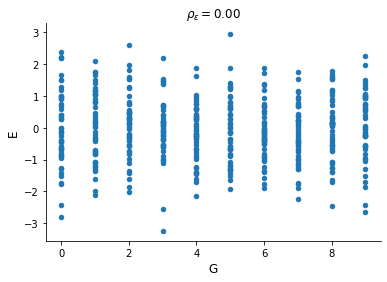

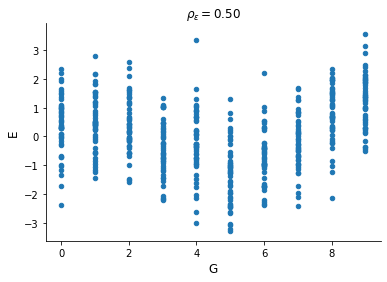

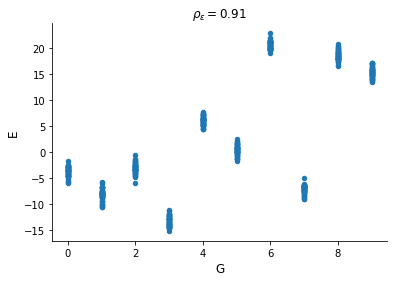

In [2]:
for scale in [0, 1, 10]:
    df = get_sample(scale)
    title = r"$\rho_\epsilon = {:5.2f}$".format(scale / (scale + 1))
    df.plot.scatter(x="G", y="E", title=title)

# Krueger (1999)

*This paper analyzes data on 11,600 students and their teachers who were randomly assigned to different size classes from kindergarten through third grade. Statistical methods are used to adjust for nonrandom attrition and transitions between classes. The main conclusions are (1) on average, performance on standardized tests increases by four percentile points the rest year students attend small classes; (2) the test score advantage of students in small classes expands by about one percentile point per year in subsequent years; (3) teacher aides and measured teacher characteristics have little effect; (4) class size has a larger effect for minority students and those on free lunch; (5) Hawthorne effects were unlikely.*

* Krueger, Alan B. (1990) Experimental estimates of education production functions, Quarterly Journal of Economics, 

In [3]:
df_base = pd.read_csv("../../datasets/processed/angrist_pischke/webstar.csv")
df_base.sample(5)

,schidkn,pscore,classid,cs,female,nwhite,n
952,35,13.858933,10300.0,24.0,1.0,1.0,1.0
4440,73,82.737686,21700.0,22.0,1.0,0.0,1.0
3549,65,71.350370,19300.0,16.0,0.0,0.0,1.0
3763,20,65.827290,5919.0,21.0,1.0,1.0,1.0
5322,22,66.374580,6318.0,16.0,0.0,1.0,1.0


## How many different classes do we have?

In [4]:
df_base["classid"].nunique()

318

## How does the distribution of class size look like?

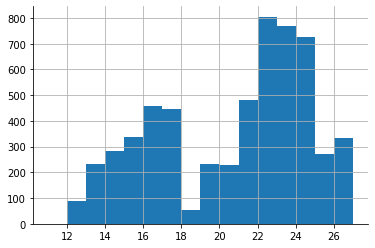

In [5]:
df_base["cs"].hist(bins=range(11, 28))

In [6]:
df_base["cs"].describe()

count    5743.00000
mean       20.28069
std         3.96193
min        12.00000
25%        17.00000
50%        22.00000
75%        23.00000
max        27.00000
Name: cs, dtype: float64

## How does the distribution of class size look like by observables?

In [7]:
for observable in ["nwhite", "female"]:
    print(df_base.groupby(observable)["cs"].mean(), "\n")

nwhite
0.0    20.063615
1.0    20.728000
Name: cs, dtype: float64 

female
0.0    20.306961
1.0    20.253038
Name: cs, dtype: float64 



Note that the randomization took place on the school level.

## What are the basic features of class size?

In [8]:
df_base.groupby("classid")["cs"].mean().describe()

count    318.000000
mean      19.424528
std        4.138642
min       12.000000
25%       16.000000
50%       20.000000
75%       23.000000
max       27.000000
Name: cs, dtype: float64

## How does the distribution of test scores look like?

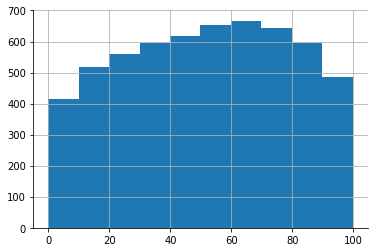

In [9]:
df_base["pscore"].hist()

## How do test scores vary overall?

In [10]:
df_base["pscore"].std()

27.05999628737241

## How do test scores vary within class?

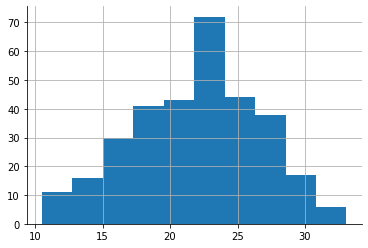

In [11]:
df_base.groupby("classid")["pscore"].std().hist()

## Is there a relationship between class size and scores?

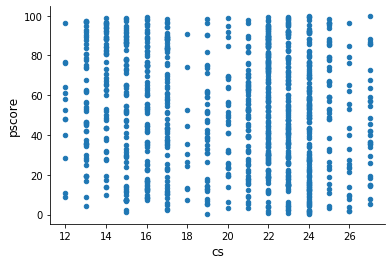

In [12]:
df_base.sample(1000).plot.scatter(x="cs", y="pscore")

In [13]:
formula = "pscore ~ cs"
rslt = smf.ols(formula=formula, data=df_base).fit()
rslt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 pscore   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     47.39
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.44e-12
Time:                        13:15:26   Log-Likelihood:                -27066.
No. Observations:                5743   AIC:                         5.414e+04
Df Residuals:                    5741   BIC:                         5.415e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     64.0666      1.855     34.536      0.000      60.430      67.703
cs            -0.6180      0.090     -6.884      0.000      -0.794      -0.442
==============================================================================
Omnibus:                     2351.698   Durbin-Watson:                   0.265
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              294.870
Skew:                          -0.070   Prob(JB):                     9.33e-65
Kurtosis:                       1.899   Cond. No.                         108.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## What is the intraclass correlation factor?

We will use this an example to illustrate the interfacing between **R** and **Python**.

In [14]:
from rpy2.robjects import DataFrame, FloatVector, IntVector  # noqa: E402
from rpy2.robjects.packages import importr  # noqa: E402

r_icc = importr("ICC")
df = DataFrame(
    {
        "groups": IntVector(df_base["classid"]),
        "values": FloatVector(rslt.resid.values),
    }
)
rslt = r_icc.ICCbare("groups", "values", data=df)[0]
print("intraclass correlation factor {:5.3f}".format(rslt))

intraclass correlation factor 0.311
